In [1]:
import iris
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
%matplotlib notebook


In [29]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)


In [ ]:
import tobac
#switch to info for less detailed output from tobac
%config tobac.log_level="DEBUG"
#%config tobac.log_level="INFO"
from tobac import plot_lifetime_histogram


In [5]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


Download example data:

In [7]:
import urllib
file_path='http://gws-access.ceda.ac.uk/public/acpc/mheiken/Tracking/Small_Example/Example_Updraft/Example_input.nc'
data_dir='Data'
os.makedirs(data_dir,exist_ok=True)
data_file=os.path.join(data_dir,'data.nc')
request=urllib.request.urlretrieve(file_path,data_file)

Load Data from downloaded file:

In [8]:
Precip=iris.load_cube(data_file,'surface_precipitation')


In [9]:
savedir='Save_Precip'
os.makedirs(savedir,exist_ok=True)


In [21]:
from tobac import get_spacings,feature_detection_multithreshold,segmentation_2D,linking_trackpy


In [11]:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=3
parameters_features['min_distance']=0
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[5,10,15] #mm/h
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=3



In [12]:
dxy,dt=get_spacings(Precip)
Features=feature_detection_multithreshold(Precip,dxy,**parameters_features)
Features.to_hdf(os.path.join(savedir,'Features.h5'),'table')

2018-11-15 17:49:58,913 | DEBUG : start feature detection based on thresholds
2018-11-15 17:49:59,990 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:50:03,235 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:50:05,823 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:50:05,826 | DEBUG : Finished feature detection for 2013-06-19_22:01:00
2018-11-15 17:50:06,549 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:50:09,982 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:50:11,981 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:50:11,984 | DEBUG : Finished feature detection for 2013-06-19_22:02:00
2018-11-15 17:50:12,452 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:50:15,463 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:50:17,511 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:50:

2018-11-15 17:52:52,488 | DEBUG : Finished feature detection for 2013-06-19_22:25:00
2018-11-15 17:52:53,264 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:52:56,985 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:52:58,891 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:52:58,894 | DEBUG : Finished feature detection for 2013-06-19_22:26:00
2018-11-15 17:52:59,635 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:53:02,775 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:53:05,396 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:53:05,399 | DEBUG : Finished feature detection for 2013-06-19_22:27:00
2018-11-15 17:53:06,083 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:53:08,825 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:53:11,022 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15

2018-11-15 17:55:19,392 | DEBUG : Finished feature detection for 2013-06-19_22:50:00
2018-11-15 17:55:20,284 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:55:24,052 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:55:25,851 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:55:25,854 | DEBUG : Finished feature detection for 2013-06-19_22:51:00
2018-11-15 17:55:26,612 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:55:29,422 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:55:32,423 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15 17:55:32,429 | DEBUG : Finished feature detection for 2013-06-19_22:52:00
2018-11-15 17:55:33,278 | DEBUG : Finished feature detection for threshold 0 : 5
2018-11-15 17:55:36,597 | DEBUG : Finished feature detection for threshold 1 : 10
2018-11-15 17:55:39,213 | DEBUG : Finished feature detection for threshold 2 : 15
2018-11-15

In [13]:
#setup for saving masks:                        
zlib=True
#zlib=False
# Set to compression level
complevel=4
packing=None
chunksizes=None
packing={'dtype': np.int32, 'scale_factor':1, 'add_offset':1}

In [14]:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=5  # mm/h mixing ratio


In [23]:
#perform 3D segmentation based on total condenate
Mask_Precip,Features_Precip=segmentation_2D(Features,Precip,dxy,**parameters_segmentation)
chunksizes=list(Mask_Precip.shape)
chunksizes[0]=1
logging.debug('segmentation Precip performed, start saving results to files')
iris.save([Mask_Precip],os.path.join(savedir,'Mask_Segmentation_precip.nc'),zlib=zlib,complevel=complevel,packing=packing,chunksizes=chunksizes)                
Features_Precip.to_hdf(os.path.join(savedir,'Features_Precip.h5'),'table')
logging.debug('segmentation Precip performed and saved')


2018-11-15 18:01:45,083 | INFO : Start wateshedding 2D
2018-11-15 18:01:46,977 | DEBUG : Finished segmentation 2D for 2013-06-19_22:01:00
2018-11-15 18:01:48,622 | DEBUG : Finished segmentation 2D for 2013-06-19_22:02:00
2018-11-15 18:01:50,580 | DEBUG : Finished segmentation 2D for 2013-06-19_22:03:00
2018-11-15 18:01:52,240 | DEBUG : Finished segmentation 2D for 2013-06-19_22:04:00
2018-11-15 18:01:54,130 | DEBUG : Finished segmentation 2D for 2013-06-19_22:05:00
2018-11-15 18:01:56,039 | DEBUG : Finished segmentation 2D for 2013-06-19_22:06:00
2018-11-15 18:01:57,870 | DEBUG : Finished segmentation 2D for 2013-06-19_22:07:00
2018-11-15 18:01:59,736 | DEBUG : Finished segmentation 2D for 2013-06-19_22:08:00
2018-11-15 18:02:01,464 | DEBUG : Finished segmentation 2D for 2013-06-19_22:09:00
2018-11-15 18:02:03,306 | DEBUG : Finished segmentation 2D for 2013-06-19_22:10:00
2018-11-15 18:02:05,273 | DEBUG : Finished segmentation 2D for 2013-06-19_22:11:00
2018-11-15 18:02:07,080 | DEBUG 

In [24]:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10
parameters_linking['d_min']=2000


In [25]:
Track=linking_trackpy(Features,Precip,dt=dt,dxy=dxy,**parameters_linking)
#save trajectories:
Track.to_hdf(os.path.join(savedir,'Track.h5'),'table')


Frame 58: 90 trajectories present.
2018-11-15 18:08:11,430 | DEBUG : cell: 1
2018-11-15 18:08:11,431 | DEBUG : feature: [  1 113]
2018-11-15 18:08:11,432 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:11,433 | DEBUG : cell1  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:11,448 | DEBUG : cell: 2
2018-11-15 18:08:11,449 | DEBUG : feature: [  2 114]
2018-11-15 18:08:11,450 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:11,452 | DEBUG : cell2  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:11,457 | DEBUG : cell: 3
2018-11-15 18:08:11,459 | DEBUG : feature: [  3 115 220]
2018-11-15 18:08:11,460 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:11,461 | DEBUG : cell3  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:11,465 | DEBUG : cell: 4
2018-11-15 18:08:11,466 | DEBUG : feature: [   4  135  244  342  445  547  657  763  872  983 1097 1200 1298 1378
 1454 1552]
2018-11-15 18:08:11,469 | DEBUG : trajectories_cell.shape[0]:

2018-11-15 18:08:11,848 | DEBUG : cell34  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:11,853 | DEBUG : cell: 35
2018-11-15 18:08:11,855 | DEBUG : feature: [ 35 126 233 330]
2018-11-15 18:08:11,856 | DEBUG : trajectories_cell.shape[0]: 4
2018-11-15 18:08:11,857 | DEBUG : cell35  is a stub (4), setting cell number to Nan..
2018-11-15 18:08:11,865 | DEBUG : cell: 36
2018-11-15 18:08:11,867 | DEBUG : feature: [ 36 140 240 337 440 544 645 748 852]
2018-11-15 18:08:11,869 | DEBUG : trajectories_cell.shape[0]: 9
2018-11-15 18:08:11,872 | DEBUG : cell: 37
2018-11-15 18:08:11,874 | DEBUG : feature: [  37  212  315  417  519  624  730  835  940 1049 1156 1258 1357 1446
 1541 1645 1752 1858 1966 2069 2167 2257 2350 2450 2552 2653 2749 2844
 2938 3032 3126 3225 3325 3429 3532 3633 3741 3845 3942 4036 4126 4218
 4311 4402 4493 4579 4664 4747 4780 4855 4926 5006]
2018-11-15 18:08:11,875 | DEBUG : trajectories_cell.shape[0]: 52
2018-11-15 18:08:11,877 | DEBUG : cell: 38
2018-11-15 18

2018-11-15 18:08:12,051 | DEBUG : trajectories_cell.shape[0]: 39
2018-11-15 18:08:12,053 | DEBUG : cell: 64
2018-11-15 18:08:12,055 | DEBUG : feature: [  64  169  271  370  475  579  688  793  899 1011 1125 1229 1325 1414
 1506 1611 1719 1828 1935 2038 2139 2230 2321 2415 2515 2616 2712 2807
 2908 2971 3065 3135 3232 3335 3444 3551]
2018-11-15 18:08:12,056 | DEBUG : trajectories_cell.shape[0]: 36
2018-11-15 18:08:12,058 | DEBUG : cell: 65
2018-11-15 18:08:12,060 | DEBUG : feature: [  65  170  272  371  476  580  689  794  866  955 1065]
2018-11-15 18:08:12,061 | DEBUG : trajectories_cell.shape[0]: 11
2018-11-15 18:08:12,063 | DEBUG : cell: 66
2018-11-15 18:08:12,065 | DEBUG : feature: [66]
2018-11-15 18:08:12,066 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:12,067 | DEBUG : cell66  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:12,076 | DEBUG : cell: 67
2018-11-15 18:08:12,078 | DEBUG : feature: [ 67 171 273 372 477 581 651 746 850]
2018-11-15 18:08:12,079 | D

2018-11-15 18:08:12,249 | DEBUG : cell: 94
2018-11-15 18:08:12,250 | DEBUG : feature: [ 94 201 304 336 430]
2018-11-15 18:08:12,251 | DEBUG : trajectories_cell.shape[0]: 5
2018-11-15 18:08:12,252 | DEBUG : cell94  is a stub (5), setting cell number to Nan..
2018-11-15 18:08:12,268 | DEBUG : cell: 95
2018-11-15 18:08:12,270 | DEBUG : feature: [  95  200  303  402  508  610  718  822  926 1035 1144 1247 1346 1435
 1528 1633 1739 1847 1955 2061 2159 2251 2344 2444 2544 2645 2683 2780
 2869 2964]
2018-11-15 18:08:12,271 | DEBUG : trajectories_cell.shape[0]: 30
2018-11-15 18:08:12,272 | DEBUG : cell: 96
2018-11-15 18:08:12,274 | DEBUG : feature: [  96  202  305  404  509  613  720  826  929 1039 1147 1249 1349 1439
 1533 1638 1744 1852 1960 2062 2161 2252 2343 2442 2542 2641 2736 2831
 2927 3021 3115 3214 3310 3415 3517 3620 3729 3832 3932]
2018-11-15 18:08:12,276 | DEBUG : trajectories_cell.shape[0]: 39
2018-11-15 18:08:12,278 | DEBUG : cell: 97
2018-11-15 18:08:12,280 | DEBUG : feature: [

2018-11-15 18:08:12,513 | DEBUG : cell: 127
2018-11-15 18:08:12,516 | DEBUG : feature: [ 332  442  626  732  836  941 1050 1092 1187]
2018-11-15 18:08:12,517 | DEBUG : trajectories_cell.shape[0]: 9
2018-11-15 18:08:12,519 | DEBUG : cell: 128
2018-11-15 18:08:12,521 | DEBUG : feature: [333 455 557 667 772 883 994]
2018-11-15 18:08:12,522 | DEBUG : trajectories_cell.shape[0]: 7
2018-11-15 18:08:12,524 | DEBUG : cell: 129
2018-11-15 18:08:12,526 | DEBUG : feature: [360 464 567]
2018-11-15 18:08:12,534 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:12,535 | DEBUG : cell129  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:12,548 | DEBUG : cell: 130
2018-11-15 18:08:12,550 | DEBUG : feature: [ 377  482  585  693  798  903  975 1067 1176 1277]
2018-11-15 18:08:12,551 | DEBUG : trajectories_cell.shape[0]: 10
2018-11-15 18:08:12,553 | DEBUG : cell: 131
2018-11-15 18:08:12,557 | DEBUG : feature: [ 396  502  605  712  817  921  976 1088 1182 1281]
2018-11-15 18:08:12,559 | 

2018-11-15 18:08:12,856 | DEBUG : cell: 162
2018-11-15 18:08:12,857 | DEBUG : feature: [ 767  878  989 1103 1206 1286 1379 1457 1555]
2018-11-15 18:08:12,858 | DEBUG : trajectories_cell.shape[0]: 9
2018-11-15 18:08:12,859 | DEBUG : cell: 163
2018-11-15 18:08:12,860 | DEBUG : feature: [788]
2018-11-15 18:08:12,861 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:12,862 | DEBUG : cell163  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:12,867 | DEBUG : cell: 164
2018-11-15 18:08:12,868 | DEBUG : feature: [843]
2018-11-15 18:08:12,869 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:12,870 | DEBUG : cell164  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:12,876 | DEBUG : cell: 165
2018-11-15 18:08:12,877 | DEBUG : feature: [ 847  967 1114 1218 1312 1400 1493 1598 1674 1770 1872 1977]
2018-11-15 18:08:12,878 | DEBUG : trajectories_cell.shape[0]: 12
2018-11-15 18:08:12,882 | DEBUG : cell: 166
2018-11-15 18:08:12,884 | DEBUG : feature: [ 855  982 10

2018-11-15 18:08:13,136 | DEBUG : trajectories_cell.shape[0]: 8
2018-11-15 18:08:13,138 | DEBUG : cell: 196
2018-11-15 18:08:13,139 | DEBUG : feature: [1285]
2018-11-15 18:08:13,140 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:13,141 | DEBUG : cell196  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:13,146 | DEBUG : cell: 197
2018-11-15 18:08:13,148 | DEBUG : feature: [1288]
2018-11-15 18:08:13,149 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:13,150 | DEBUG : cell197  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:13,155 | DEBUG : cell: 198
2018-11-15 18:08:13,156 | DEBUG : feature: [1319 1406 1500 1576 1675]
2018-11-15 18:08:13,157 | DEBUG : trajectories_cell.shape[0]: 5
2018-11-15 18:08:13,158 | DEBUG : cell198  is a stub (5), setting cell number to Nan..
2018-11-15 18:08:13,163 | DEBUG : cell: 199
2018-11-15 18:08:13,164 | DEBUG : feature: [1331 1421 1513 1619 1726 1835 1942 2046 2146 2196 2288 2372 2467]
2018-11-15 18:08:13,165 | D

2018-11-15 18:08:13,316 | DEBUG : cell: 228
2018-11-15 18:08:13,318 | DEBUG : feature: [1568 1668 1784]
2018-11-15 18:08:13,319 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:13,320 | DEBUG : cell228  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:13,325 | DEBUG : cell: 229
2018-11-15 18:08:13,326 | DEBUG : feature: [1569]
2018-11-15 18:08:13,327 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:13,328 | DEBUG : cell229  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:13,332 | DEBUG : cell: 230
2018-11-15 18:08:13,333 | DEBUG : feature: [1571 1689 1863 1901 1995]
2018-11-15 18:08:13,334 | DEBUG : trajectories_cell.shape[0]: 5
2018-11-15 18:08:13,335 | DEBUG : cell230  is a stub (5), setting cell number to Nan..
2018-11-15 18:08:13,341 | DEBUG : cell: 231
2018-11-15 18:08:13,344 | DEBUG : feature: [1573 1698 1807 1913 2018 2118 2214]
2018-11-15 18:08:13,345 | DEBUG : trajectories_cell.shape[0]: 7
2018-11-15 18:08:13,348 | DEBUG : cell: 232
201

2018-11-15 18:08:13,712 | DEBUG : feature: [2089 2185 2280 2439 2540 2639 2735 2830 2926 3019 3114 3213 3308 3413
 3516 3617 3728 3831 3931 4027 4117 4209 4301 4346 4435 4515 4601 4685]
2018-11-15 18:08:13,713 | DEBUG : trajectories_cell.shape[0]: 28
2018-11-15 18:08:13,715 | DEBUG : cell: 263
2018-11-15 18:08:13,716 | DEBUG : feature: [2101 2234 2327 2420 2521 2621 2717 2812 2879 2960 3045 3140 3237]
2018-11-15 18:08:13,717 | DEBUG : trajectories_cell.shape[0]: 13
2018-11-15 18:08:13,718 | DEBUG : cell: 264
2018-11-15 18:08:13,719 | DEBUG : feature: [2123]
2018-11-15 18:08:13,721 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:13,721 | DEBUG : cell264  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:13,727 | DEBUG : cell: 265
2018-11-15 18:08:13,729 | DEBUG : feature: [2178 2271 2367 2461 2562 2662 2758 2859 2954]
2018-11-15 18:08:13,730 | DEBUG : trajectories_cell.shape[0]: 9
2018-11-15 18:08:13,732 | DEBUG : cell: 266
2018-11-15 18:08:13,733 | DEBUG : feature: 

2018-11-15 18:08:14,029 | DEBUG : cell: 296
2018-11-15 18:08:14,031 | DEBUG : feature: [2483 2586 2684 2781 2933 3026 3119 3218 3316 3422 3525 3626 3674 3778
 3862 3964 4055 4148]
2018-11-15 18:08:14,038 | DEBUG : trajectories_cell.shape[0]: 18
2018-11-15 18:08:14,041 | DEBUG : cell: 297
2018-11-15 18:08:14,047 | DEBUG : feature: [2484 2647 2744 2838]
2018-11-15 18:08:14,049 | DEBUG : trajectories_cell.shape[0]: 4
2018-11-15 18:08:14,056 | DEBUG : cell297  is a stub (4), setting cell number to Nan..
2018-11-15 18:08:14,062 | DEBUG : cell: 298
2018-11-15 18:08:14,066 | DEBUG : feature: [2494 2581]
2018-11-15 18:08:14,068 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:14,070 | DEBUG : cell298  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:14,079 | DEBUG : cell: 299
2018-11-15 18:08:14,081 | DEBUG : feature: [2495 2598 2696 2793 2896 2988 3083 3175 3269 3369 3474]
2018-11-15 18:08:14,083 | DEBUG : trajectories_cell.shape[0]: 11
2018-11-15 18:08:14,085 | DEBUG : ce

2018-11-15 18:08:14,339 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:14,340 | DEBUG : cell328  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:14,351 | DEBUG : cell: 329
2018-11-15 18:08:14,358 | DEBUG : feature: [2966 3071 3164 3258 3360 3461 3557 3657]
2018-11-15 18:08:14,359 | DEBUG : trajectories_cell.shape[0]: 8
2018-11-15 18:08:14,361 | DEBUG : cell: 330
2018-11-15 18:08:14,363 | DEBUG : feature: [2968 3055]
2018-11-15 18:08:14,365 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:14,366 | DEBUG : cell330  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:14,377 | DEBUG : cell: 331
2018-11-15 18:08:14,379 | DEBUG : feature: [3028 3122 3161]
2018-11-15 18:08:14,380 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:14,381 | DEBUG : cell331  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:14,392 | DEBUG : cell: 332
2018-11-15 18:08:14,394 | DEBUG : feature: [3038 3153 3272 3371 3476 3578 3690 3794 3892 3990 4081 4173 426

2018-11-15 18:08:14,602 | DEBUG : cell362  is a stub (5), setting cell number to Nan..
2018-11-15 18:08:14,611 | DEBUG : cell: 363
2018-11-15 18:08:14,613 | DEBUG : feature: [3259 3435 3537 3640 3747 3760]
2018-11-15 18:08:14,616 | DEBUG : trajectories_cell.shape[0]: 6
2018-11-15 18:08:14,617 | DEBUG : cell: 364
2018-11-15 18:08:14,619 | DEBUG : feature: [3288]
2018-11-15 18:08:14,620 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:14,622 | DEBUG : cell364  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:14,630 | DEBUG : cell: 365
2018-11-15 18:08:14,631 | DEBUG : feature: [3312 3416 3520 3622 3733 3775 3878 4031 4120 4212 4304 4392 4485 4571
 4656 4739 4818 4899 4980 5063 5098 5189 5267 5356 5435]
2018-11-15 18:08:14,633 | DEBUG : trajectories_cell.shape[0]: 25
2018-11-15 18:08:14,635 | DEBUG : cell: 366
2018-11-15 18:08:14,636 | DEBUG : feature: [3318 3423]
2018-11-15 18:08:14,638 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:14,639 | DEBUG : cell366 

2018-11-15 18:08:15,004 | DEBUG : cell: 397
2018-11-15 18:08:15,006 | DEBUG : feature: [3691 3795 3894 3992 4083 4176 4270 4360 4451 4540 4624 4711 4789 4864
 4928 4994]
2018-11-15 18:08:15,007 | DEBUG : trajectories_cell.shape[0]: 16
2018-11-15 18:08:15,010 | DEBUG : cell: 398
2018-11-15 18:08:15,012 | DEBUG : feature: [3692 3765]
2018-11-15 18:08:15,013 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:15,015 | DEBUG : cell398  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:15,030 | DEBUG : cell: 399
2018-11-15 18:08:15,033 | DEBUG : feature: [3740 3841 3940]
2018-11-15 18:08:15,036 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:15,038 | DEBUG : cell399  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:15,051 | DEBUG : cell: 400
2018-11-15 18:08:15,053 | DEBUG : feature: [3752 3870 3970 4064 4157 4232]
2018-11-15 18:08:15,054 | DEBUG : trajectories_cell.shape[0]: 6
2018-11-15 18:08:15,056 | DEBUG : cell: 401
2018-11-15 18:08:15,058 | DEBUG :

2018-11-15 18:08:15,356 | DEBUG : cell: 432
2018-11-15 18:08:15,359 | DEBUG : feature: [4229]
2018-11-15 18:08:15,362 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:15,364 | DEBUG : cell432  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:15,378 | DEBUG : cell: 433
2018-11-15 18:08:15,382 | DEBUG : feature: [4230 4337 4430 4504 4589 4675 4757 4834 4914 5009 5114 5204 5294 5376
 5457 5537 5600]
2018-11-15 18:08:15,384 | DEBUG : trajectories_cell.shape[0]: 17
2018-11-15 18:08:15,388 | DEBUG : cell: 434
2018-11-15 18:08:15,390 | DEBUG : feature: [4231 4323 4415]
2018-11-15 18:08:15,406 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:15,408 | DEBUG : cell434  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:15,423 | DEBUG : cell: 435
2018-11-15 18:08:15,426 | DEBUG : feature: [4238 4327]
2018-11-15 18:08:15,427 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:15,428 | DEBUG : cell435  is a stub (2), setting cell number to Nan..
2018-11-15

2018-11-15 18:08:15,816 | DEBUG : cell: 467
2018-11-15 18:08:15,822 | DEBUG : feature: [4673 4755 4868 4947 5028 5111 5202 5292 5374 5455 5533 5619]
2018-11-15 18:08:15,827 | DEBUG : trajectories_cell.shape[0]: 12
2018-11-15 18:08:15,830 | DEBUG : cell: 468
2018-11-15 18:08:15,832 | DEBUG : feature: [4678 4773 4873 4953 5035 5121 5210 5300 5382 5465 5543 5629]
2018-11-15 18:08:15,833 | DEBUG : trajectories_cell.shape[0]: 12
2018-11-15 18:08:15,835 | DEBUG : cell: 469
2018-11-15 18:08:15,837 | DEBUG : feature: [4680 4761 4850 4933 5037 5123 5212 5302 5384 5467 5549 5634]
2018-11-15 18:08:15,838 | DEBUG : trajectories_cell.shape[0]: 12
2018-11-15 18:08:15,840 | DEBUG : cell: 470
2018-11-15 18:08:15,842 | DEBUG : feature: [4689]
2018-11-15 18:08:15,843 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:15,844 | DEBUG : cell470  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:15,858 | DEBUG : cell: 471
2018-11-15 18:08:15,865 | DEBUG : feature: [4691]
2018-11-15 18:08:15

2018-11-15 18:08:16,241 | DEBUG : trajectories_cell.shape[0]: 7
2018-11-15 18:08:16,243 | DEBUG : cell: 505
2018-11-15 18:08:16,245 | DEBUG : feature: [5105]
2018-11-15 18:08:16,247 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:16,248 | DEBUG : cell505  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:16,257 | DEBUG : cell: 506
2018-11-15 18:08:16,260 | DEBUG : feature: [5125 5185 5274]
2018-11-15 18:08:16,262 | DEBUG : trajectories_cell.shape[0]: 3
2018-11-15 18:08:16,263 | DEBUG : cell506  is a stub (3), setting cell number to Nan..
2018-11-15 18:08:16,271 | DEBUG : cell: 507
2018-11-15 18:08:16,274 | DEBUG : feature: [5126]
2018-11-15 18:08:16,275 | DEBUG : trajectories_cell.shape[0]: 1
2018-11-15 18:08:16,277 | DEBUG : cell507  is a stub (1), setting cell number to Nan..
2018-11-15 18:08:16,286 | DEBUG : cell: 508
2018-11-15 18:08:16,288 | DEBUG : feature: [5129 5216]
2018-11-15 18:08:16,290 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:16,291 | DE

2018-11-15 18:08:16,733 | DEBUG : cell: 539
2018-11-15 18:08:16,735 | DEBUG : feature: [5524 5676]
2018-11-15 18:08:16,736 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:16,737 | DEBUG : cell539  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:16,749 | DEBUG : cell: 540
2018-11-15 18:08:16,753 | DEBUG : feature: [5532 5620]
2018-11-15 18:08:16,755 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:16,756 | DEBUG : cell540  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:16,771 | DEBUG : cell: 541
2018-11-15 18:08:16,773 | DEBUG : feature: [5534 5621]
2018-11-15 18:08:16,774 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:16,776 | DEBUG : cell541  is a stub (2), setting cell number to Nan..
2018-11-15 18:08:16,784 | DEBUG : cell: 542
2018-11-15 18:08:16,786 | DEBUG : feature: [5544 5603]
2018-11-15 18:08:16,787 | DEBUG : trajectories_cell.shape[0]: 2
2018-11-15 18:08:16,789 | DEBUG : cell542  is a stub (2), setting cell number to Nan..


Plot some results for a specific timestep:
    

2018-11-15 18:08:27,163 | DEBUG : update_title_pos
2018-11-15 18:08:28,005 | DEBUG : update_title_pos
2018-11-15 18:08:28,330 | DEBUG : update_title_pos
2018-11-15 18:08:28,671 | DEBUG : update_title_pos
2018-11-15 18:08:28,873 | DEBUG : update_title_pos


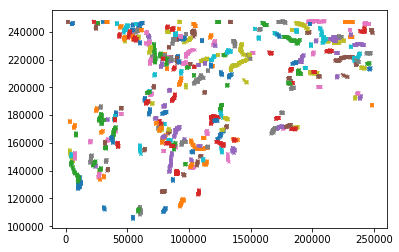

In [26]:
fig1,ax1=plt.subplots()
for cell in Track['cell'].dropna().unique():
    Track_i=Track[Track['cell']==cell]
    ax1.plot(Track_i['projection_x_coordinate'],Track_i['projection_y_coordinate'],'-x',markersize=3)

In [27]:
plot_dir="Plots_Precip"
os.makedirs(plot_dir,exist_ok=True)


In [28]:
from tobac import plot_tracks_mask_field_loop
axis_extent=[-96.3,-93.9,28.4,30.5]
plot_tracks_mask_field_loop(track=Track,field=Precip,mask=Mask_Precip,features=Features,
                            plot_dir=plot_dir,name='Precip',
                            axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                            vmin=0,vmax=30,
                            plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)
        


2018-11-15 18:08:31,414 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5de84343c8>
2018-11-15 18:08:31,416 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:08:31,432 | DEBUG : Setting pcolormesh
2018-11-15 18:08:31,437 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5de84526d8>
2018-11-15 18:08:31,439 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:08:37,604 | DEBUG : update_title_pos
2018-11-15 18:08:40,294 | DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0 to DejaVu Sans ('/home/users/mheiken/miniconda3/envs/acpc/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-15 18:08:40,433 | DEBUG : update_title_pos
2018-11-15 18:08:41,269 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:01:00.png
2018-11-15 18:08:43,472 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5de82e0fd0>
2018-11-15 18:08:43,

2018-11-15 18:10:50,479 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:10:56,547 | DEBUG : update_title_pos
2018-11-15 18:10:57,627 | DEBUG : update_title_pos
2018-11-15 18:10:58,393 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:14:00.png
2018-11-15 18:11:00,860 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dc988bac8>
2018-11-15 18:11:00,865 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:11:00,887 | DEBUG : Setting pcolormesh
2018-11-15 18:11:00,893 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5dc98a4c88>
2018-11-15 18:11:00,895 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:11:07,552 | DEBUG : update_title_pos
2018-11-15 18:11:08,897 | DEBUG : update_title_pos
2018-11-15 18:11:09,636 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:15:00.png
2018-11-15 18:11:11,671 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dc8d50cf8>
2018-11-15 18:11:11,672 | DEBUG : Using fixed locat

2018-11-15 18:13:19,571 | DEBUG : update_title_pos
2018-11-15 18:13:20,541 | DEBUG : update_title_pos
2018-11-15 18:13:21,205 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:28:00.png
2018-11-15 18:13:23,345 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dbfc7efd0>
2018-11-15 18:13:23,346 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:13:23,360 | DEBUG : Setting pcolormesh
2018-11-15 18:13:23,363 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5dbfc18cc0>
2018-11-15 18:13:23,364 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:13:29,046 | DEBUG : update_title_pos
2018-11-15 18:13:29,990 | DEBUG : update_title_pos
2018-11-15 18:13:30,772 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:29:00.png
2018-11-15 18:13:33,084 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dbf172780>
2018-11-15 18:13:33,085 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:13:33,108 | DEBUG : Setting pcolormes

2018-11-15 18:15:39,256 | DEBUG : update_title_pos
2018-11-15 18:15:40,111 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:42:00.png
2018-11-15 18:15:41,826 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5db61205f8>
2018-11-15 18:15:41,828 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:15:41,844 | DEBUG : Setting pcolormesh
2018-11-15 18:15:41,851 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5db613b160>
2018-11-15 18:15:41,852 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:15:47,700 | DEBUG : update_title_pos
2018-11-15 18:15:48,921 | DEBUG : update_title_pos
2018-11-15 18:15:49,389 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:43:00.png
2018-11-15 18:15:51,266 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5db5690e10>
2018-11-15 18:15:51,267 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:15:51,285 | DEBUG : Setting pcolormesh
2018-11-15 18:15:51,289 | DEBUG : locator: <matpl

2018-11-15 18:17:44,629 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:56:00.png
2018-11-15 18:17:46,277 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dad931b70>
2018-11-15 18:17:46,278 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:17:46,299 | DEBUG : Setting pcolormesh
2018-11-15 18:17:46,305 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5dad8cd6d8>
2018-11-15 18:17:46,307 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:17:51,100 | DEBUG : update_title_pos
2018-11-15 18:17:52,465 | DEBUG : update_title_pos
2018-11-15 18:17:53,181 | DEBUG : Figure plotted to Plots_Precip/Precip_2013-06-19_22:57:00.png
2018-11-15 18:17:55,051 | DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f5dacf67dd8>
2018-11-15 18:17:55,052 | DEBUG : Using fixed locator on colorbar
2018-11-15 18:17:55,067 | DEBUG : Setting pcolormesh
2018-11-15 18:17:55,074 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x7f5dacf79940>
